In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

In [2]:
device = torch.device('cuda:3')
print(device)

cuda:3


In [205]:
x = torch.randn(5, 3)
x = x.to(device)

for i in range(10):
    y = x**2
    time.sleep(1)

In [3]:
embedding_dir = '~/vibrio_embeddings/'
positive_pairs = pd.read_table(embedding_dir + 'pairs_positive.txt')
positive_pairs

,bacterial_host,phage,bacterial_id,phage_id
0,10N.261.51.C9,1.011.O.,GCA_002876255.1,GCA_003926235.1
1,10N.222.52.A7,1.011.O.,GCA_002876565.1,GCA_003926235.1
2,10N.261.51.B8,1.011.O.,GCA_002876225.1,GCA_003926235.1
3,10N.261.52.C7,1.011.O.,GCA_002876415.1,GCA_003926235.1
4,10N.261.55.E8,1.011.O.,GCA_002877535.1,GCA_003926235.1
...,...,...,...,...
1371,10N.286.52.F9,1.266.O.,GCA_002873715.1,GCA_003930675.1
1372,10N.286.54.F2,1.197.A.,GCA_002874845.1,GCA_003929395.1
1373,10N.286.55.C10,1.199.A.,GCA_002874035.1,GCA_003929455.1
1374,10N.286.55.C4,1.286.O.,GCA_002872705.1,GCA_003931175.1


In [4]:
for bact in positive_pairs['bacterial_id'].unique():
    try:
        print(torch.load('/home/ec2-user/vibrio_embeddings/host_embeddings/' + bact + '.pt').size())
    except:
        print('Not found: ' + bact)

torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([12, 4096])
torch.Size([8, 4096])
torch.Size([7, 4096])
torch.Size([26, 4096])
torch.Size([1, 4096])
torch.Size([13, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([67, 4096])
torch.Size([1, 4096])
torch.Size([9, 4096])
torch.Size([8, 4096])
torch.Size([5, 4096])
torch.Size([2, 4096])
torch.Size([1, 4096])
torch.Size([4, 4096])
torch.Size([2, 4096])
torch.Size([4, 4096])
torch.Size([26, 4096])
torch.Size([4, 4096])
torch.Size([12, 4096])
torch.Size([11, 4096])
Not found: GCA_020806385.1
torch.Size([6, 4096])
torch.Size([3, 4096])
torch.Size([1, 4096])
torch.Size([2, 4096])
torch.Size([5, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([2, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([4, 4096])
torch.Size([1, 4096])
torch.Size([4, 4096])
torch.Size([1, 4096])
torch.Size([2, 4096])
torch.Size([12, 4096])
torch.Size([6, 4096])
torch.Size([8, 4096

In [5]:
for phage in positive_pairs['phage_id'].unique():
    try:
        print(torch.load('/home/ec2-user/vibrio_embeddings/phage_embeddings/' + phage + '.pt').size())
    except:
        print('Not found: ' + phage)

torch.Size([1, 4096])
Not found: GCA_003927055.1
Not found: GCA_003926795.1
Not found: GCA_003926855.1
Not found: GCA_003926835.1
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
Not found: GCA_003926915.1
Not found: GCA_003926995.1
torch.Size([1, 4096])
Not found: GCA_003931455.1
torch.Size([2, 4096])
torch.Size([2, 4096])
torch.Size([2, 4096])
Not found: GCA_003926655.1
torch.Size([2, 4096])
torch.Size([1, 4096])
torch.Size([2, 4096])
torch.Size([2, 4096])
torch.Size([1, 4096])
torch.Size([4, 4096])
torch.Size([2, 4096])
torch.Size([2, 4096])
torch.Size([2, 4096])
torch.Size([2, 4096])
Not found: GCA_003927075.1
torch.Size([2, 4096])
torch.Size([2, 4096])
Not found: GCA_003926675.1
torch.Size([2, 4096])
torch.Size([2, 4096])
torch.Size([2, 4096])
torch.Size([2, 4096])
torch.Size([2, 4096])
torch.Size([2, 4096])
torch.Size([2, 4096])
torch.Size([2, 4096])
torc

In [6]:
print(positive_pairs.shape)
for i in positive_pairs.index:
    pair = positive_pairs.loc[i]
    # print(os.path.isfile('/home/ec2-user/vibrio_embeddings/phage_embeddings/' + pair['phage_id'] + '.pt'))
    # continue
    if (not os.path.isfile('/home/ec2-user/vibrio_embeddings/phage_embeddings/' + pair['phage_id'] + '.pt')) or (not os.path.isfile('/home/ec2-user/vibrio_embeddings/host_embeddings/' + pair['bacterial_id'] + '.pt')):
        positive_pairs = positive_pairs.drop(i)
print(positive_pairs.shape)


(1376, 4)
(1088, 4)


In [7]:
unique_bacteria = positive_pairs['bacterial_id'].unique()
unique_phage = positive_pairs['phage_id'].unique()
print(len(unique_bacteria))
print(len(unique_phage))

positive_pair_list = list(zip(positive_pairs['bacterial_id'].values, positive_pairs['phage_id'].values))
print(len(positive_pair_list))

negative_pairs = []
for bact in unique_bacteria:
    for phage in unique_phage:
        if (bact, phage) not in positive_pair_list:
            negative_pairs.append((bact, phage))
print(len(negative_pairs))
print(len(set(positive_pair_list).intersection(set(negative_pairs))))


"""negative_hosts = np.random.choice(positive_pairs['bacterial_id'], len(positive_pairs), replace=True)
# negative_phages = np.random.choice(positive_pairs['phage_id'], len(positive_pairs), replace=True)

# negative_pairs = list(zip(negative_hosts, negative_phages))
positive_pair_list = list(zip(positive_pairs['bacterial_id'].values, positive_pairs['phage_id'].values))

negative_pairs = []
for host in negative_hosts:
    match = False
    while not match:
        potential_phage = np.random.choice(positive_pairs['phage_id'], 1)[0]
        if (host, potential_phage) not in positive_pair_list:
            match = True
    negative_pairs.append((host, potential_phage))

print(len(negative_pairs))
print(len(positive_pair_list))
print(len(set(positive_pair_list).intersection(set(negative_pairs))))"""

247
213
1088
51523
0


"negative_hosts = np.random.choice(positive_pairs['bacterial_id'], len(positive_pairs), replace=True)\n# negative_phages = np.random.choice(positive_pairs['phage_id'], len(positive_pairs), replace=True)\n\n# negative_pairs = list(zip(negative_hosts, negative_phages))\npositive_pair_list = list(zip(positive_pairs['bacterial_id'].values, positive_pairs['phage_id'].values))\n\nnegative_pairs = []\nfor host in negative_hosts:\n    match = False\n    while not match:\n        potential_phage = np.random.choice(positive_pairs['phage_id'], 1)[0]\n        if (host, potential_phage) not in positive_pair_list:\n            match = True\n    negative_pairs.append((host, potential_phage))\n\nprint(len(negative_pairs))\nprint(len(positive_pair_list))\nprint(len(set(positive_pair_list).intersection(set(negative_pairs))))"

In [8]:
negative_pairs = pd.DataFrame(negative_pairs, columns=['bacterial_id', 'phage_id'])
positive_pairs_split = positive_pairs[['bacterial_id', 'phage_id']]
negative_pairs['Label'] = 0
positive_pairs_split['Label'] = 1
full_pairs = pd.concat([positive_pairs_split, negative_pairs])
full_pairs

/tmp/ipykernel_35699/230755662.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_pairs_split['Label'] = 1


,bacterial_id,phage_id,Label
0,GCA_002876255.1,GCA_003926235.1,1
1,GCA_002876565.1,GCA_003926235.1,1
2,GCA_002876225.1,GCA_003926235.1,1
3,GCA_002876415.1,GCA_003926235.1,1
4,GCA_002877535.1,GCA_003926235.1,1
...,...,...,...
51518,GCA_002872635.1,GCA_003344145.1,0
51519,GCA_002872635.1,GCA_003930675.1,0
51520,GCA_002872635.1,GCA_003929395.1,0
51521,GCA_002872635.1,GCA_003929455.1,0


In [9]:
train, temp = train_test_split(full_pairs, test_size=0.3, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)
print(train.shape)
print(val.shape)
print(test.shape)

(36827, 3)
(7892, 3)
(7892, 3)


In [10]:
print(train['Label'].value_counts())
print(val['Label'].value_counts())
print(test['Label'].value_counts())

Label
0    36080
1      747
Name: count, dtype: int64
Label
0    7725
1     167
Name: count, dtype: int64
Label
0    7718
1     174
Name: count, dtype: int64


In [52]:
class PhageBactPairDataset(Dataset):
    def __init__(self, pair_df, method):
        self.pairs = pair_df[['bacterial_id', 'phage_id']]
        self.labels = pair_df['Label'].values
        self.method = method
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        pair = self.pairs.iloc[idx]
        label = self.labels[idx]
        if self.method == 'mean':
            pair_phage = torch.mean(torch.load('/home/ec2-user/vibrio_embeddings/phage_embeddings/' + pair['phage_id'] + '.pt'), 0)
            pair_phage = pair_phage/torch.max(pair_phage)
            pair_bact = torch.mean(torch.load('/home/ec2-user/vibrio_embeddings/host_embeddings/' + pair['bacterial_id'] + '.pt'), 0)
            pair_bact = pair_bact/torch.max(pair_bact)
        elif self.method == 'sum':
            pair_phage = torch.sum(torch.load('/home/ec2-user/vibrio_embeddings/phage_embeddings/' + pair['phage_id'] + '.pt'), 0)
            pair_phage = pair_phage/torch.max(pair_phage)
            pair_bact = torch.sum(torch.load('/home/ec2-user/vibrio_embeddings/host_embeddings/' + pair['bacterial_id'] + '.pt'), 0)
            pair_bact = pair_bact/torch.max(pair_bact)

        return pair_phage, pair_bact, torch.tensor(label)

In [59]:
class TestDataset(Dataset):
    def __init__(self, id_list, method, phage=True):
        self.id_list = id_list
        self.method = method
        self.phage = phage
        
    def __len__(self):
        return len(self.id_list)
    
    def __getitem__(self, idx):
        ID = self.id_list[idx]
        if self.method == 'mean':
            if self.phage:
                embed = torch.mean(torch.load('/home/ec2-user/vibrio_embeddings/phage_embeddings/' + ID + '.pt'), 0)
                embed = embed/torch.max(embed)
            else:
                embed = torch.mean(torch.load('/home/ec2-user/vibrio_embeddings/host_embeddings/' + ID + '.pt'), 0)
                embed = embed/torch.max(embed)
        elif self.method == 'sum':
            if self.phage:
                embed = torch.sum(torch.load('/home/ec2-user/vibrio_embeddings/phage_embeddings/' + ID + '.pt'), 0)
                embed = embed/torch.max(embed)
            else:
                embed = torch.sum(torch.load('/home/ec2-user/vibrio_embeddings/host_embeddings/' + ID + '.pt'), 0)
                embed = embed/torch.max(embed)
        
        return ID, embed

In [53]:
# Simple one-layer linear network, symmetrical for phage and host encodings, will have to flatten input

class SimpleEmbedding(nn.Module):
    def __init__(self, input_dim=4096, hidden_dim=1024, output_dim=512):
        super(SimpleEmbedding, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # print(torch.flatten(x, 1))
        return self.fc2(F.relu(self.fc1(torch.flatten(x, 1))))

In [14]:
# CNN network, each channel is a bin of the genome (phage will probably only have one channel)

class CNNEmbedding(nn.Module):
    def __init__(self):
        super(CNNEmbedding, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, (1,3), stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, (1,3), stride=1)
        self.bn2 = nn.BatchNorm2d(128) 
        self.fc1 = nn.Linear(128*1022, 1024)
        self.fc2 = nn.Linear(1024, 512)
        
    def forward(self, x):
        x = self.bn1(F.max_pool2d(F.relu(self.conv1(x)), (1,2)))
        x = self.bn2(F.max_pool2d(F.relu(self.conv2(x)), (1,2)))
        return self.fc2(F.relu(self.fc1(torch.flatten(x, 1))))

In [54]:
# Euclidean distance, can also try to implement CLIP-like cosigne similarity matrix with cross-entropy loss

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, phage, bact, label):
        p_h_distance = phage - bact
        dist_norm_squared = torch.sum(torch.pow(p_h_distance, 2), 1)
        dist_norm = torch.sqrt(dist_norm_squared)
        neg = torch.pow(torch.clamp(self.margin - dist_norm, min=0), 2)
        loss_per_batch = label*dist_norm_squared + (1 - label)*neg
        return 0.5*torch.mean(loss_per_batch)

In [45]:
def predict(loader, encoder):
    ids = []
    output_embeddings  = []
    with torch.no_grad():
        for batch in loader:
            embed = batch[1].to(device)
            ids.append(batch[0])
            output_embeddings.append(encoder(embed).cpu())
    ids = np.concatenate(ids)
    output_embeddings = np.concatenate(output_embeddings)
    
    return ids, output_embeddings

In [17]:
def get_neighbor_list(phage_ids, phage_embeddings, bact_ids, bact_embeddings):
    sorted_neighbor_list = {}
    
    with torch.no_grad():
        all_distances = []
        for i in range(len(phage_ids)):
            distances = []
            for bact in bact_embeddings:
                # distances.append(torch.sqrt(torch.sum(torch.pow(phage_embeddings[i] - bact, 2), 1)))
                distances.append(np.linalg.norm(phage_embeddings[i] - bact))
            all_distances.append(distances)
    
    all_distances = np.array(all_distances)
    print(all_distances.shape)
    print(np.argsort(all_distances))

In [18]:
def get_top_k_accuracy(neighbor_list, bact_ids, pairs, k):
    pass

In [19]:
device

device(type='cuda', index=3)

In [55]:
# train_dataset = PhageBactPairDataset(pair_df=train, method='mean')
train_dataset = PhageBactPairDataset(pair_df=train, method='sum')
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# val_dataset = PhageBactPairDataset(pair_df=val, method='mean')
val_dataset = PhageBactPairDataset(pair_df=val, method='sum')
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)

100%|██████████| 144/144 [00:33<00:00,  4.33it/s]


        Euclidean Distance
Labels                    
0.0               0.262368
1.0               0.261298
        Euclidean Distance
Labels                    
0.0               0.031791
1.0               0.053993
        Euclidean Distance
Labels                    
0.0               1.942749
1.0               1.913314


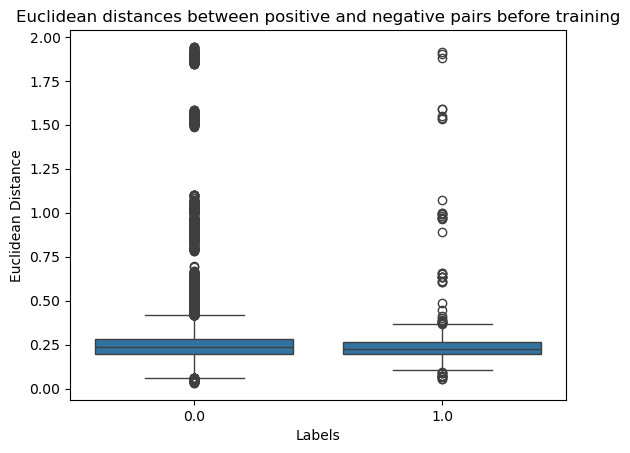

In [56]:
distances = []
labels = []
with tqdm.tqdm(total=len(train_loader)) as pbar:
    for batch in train_loader:
        pbar.update(1)
        
        distances.append(torch.sqrt(torch.sum(torch.pow(batch[0] - batch[1], 2), 1)))
        labels.append(batch[2])

distances = np.concatenate(distances)
labels = np.concatenate(labels)

temp = pd.DataFrame([distances, labels], index=['Euclidean Distance', 'Labels']).transpose()
gb = temp.groupby('Labels')
print(gb.mean())
print(gb.min())
print(gb.max())
plt.title('Euclidean distances between positive and negative pairs before training')
sns.boxplot(data=temp, x='Labels', y='Euclidean Distance')
plt.show()

In [57]:
torch.manual_seed(42)

# phage_encoder = SimpleEmbedding().to(device)
# bacteria_encoder = SimpleEmbedding().to(device)
encoder = SimpleEmbedding().to(device)
# phage_optimizer = torch.optim.Adam(phage_encoder.parameters(), lr=0.001)
# bacteria_optimizer = torch.optim.Adam(bacteria_encoder.parameters(), lr=0.001)
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
criterion = ContrastiveLoss(margin=1)

training_loss = []
validation_loss = []
for epoch in range(25):
    with tqdm.tqdm(total=len(train_loader), desc='Epoch ' + str(epoch+1)) as pbar:
        batch_train_loss = 0
        count = 0
        for batch in train_loader:
            pbar.update(1)

            batch_phage = batch[0].to(device)
            batch_bacteria = batch[1].to(device)
            batch_labels = batch[2].to(device)

            # print(batch_phage.device)
            # print(phage_encoder.device)

            # phage_batch_embed = phage_encoder(batch_phage)
            # bact_batch_embed = bacteria_encoder(batch_bacteria)
            phage_batch_embed = encoder(batch_phage)
            bact_batch_embed = encoder(batch_bacteria)

            train_loss = criterion(phage_batch_embed, bact_batch_embed, batch_labels)
            batch_train_loss += train_loss.item()
            count += 1

            # phage_optimizer.zero_grad()
            # bacteria_optimizer.zero_grad()
            optimizer.zero_grad()
            train_loss.backward()
            # phage_optimizer.step()
            # bacteria_optimizer.step()
            optimizer.step()
            
        training_loss.append(batch_train_loss/count)

        with torch.no_grad():
            batch_val_loss = 0
            count = 0
            for batch in val_loader:
                val_batch_phage = batch[0].to(device)
                val_batch_bacteria = batch[1].to(device)
                val_batch_labels = batch[2].to(device)

                # phage_batch_embed_val = phage_encoder(val_batch_phage)
                # bact_batch_embed_val = bacteria_encoder(val_batch_bacteria)
                phage_batch_embed_val = encoder(val_batch_phage)
                bact_batch_embed_val = encoder(val_batch_bacteria)

                val_loss = criterion(phage_batch_embed_val, bact_batch_embed_val, val_batch_labels)
                batch_val_loss += val_loss.item()
                count += 1

        validation_loss.append(batch_val_loss/count)

        print(training_loss[-1])
        print(validation_loss[-1])

Epoch 1:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 144/144 [00:41<00:00,  3.51it/s]


0.03505534311989322
0.020346414928715074


Epoch 2: 100%|██████████| 144/144 [00:40<00:00,  3.56it/s]


0.018701311307571206
0.020357683391099977


Epoch 3: 100%|██████████| 144/144 [00:40<00:00,  3.55it/s]


0.01879673235493505
0.020151657803404714


Epoch 4: 100%|██████████| 144/144 [00:40<00:00,  3.53it/s]


0.018203582737543102
0.01962983644297046


Epoch 5: 100%|██████████| 144/144 [00:39<00:00,  3.63it/s]


0.018255095382402133
0.019925882378893513


Epoch 6: 100%|██████████| 144/144 [00:40<00:00,  3.55it/s]


0.017947354881067037
0.019904735287831675


Epoch 7: 100%|██████████| 144/144 [00:42<00:00,  3.35it/s]


0.018521967259908304
0.018718947626409993


Epoch 8: 100%|██████████| 144/144 [00:40<00:00,  3.60it/s]


0.017860705138041846
0.020396785525184487


Epoch 9: 100%|██████████| 144/144 [00:41<00:00,  3.51it/s]


0.01794512970890436
0.01933171509975387


Epoch 10: 100%|██████████| 144/144 [00:40<00:00,  3.55it/s]


0.017500096046003617
0.01865874453177375


Epoch 11: 100%|██████████| 144/144 [00:43<00:00,  3.30it/s]


0.017981714468785666
0.018884282874604388


Epoch 12: 100%|██████████| 144/144 [00:47<00:00,  3.05it/s]


0.018433208262043383
0.02091165028151966


Epoch 13:  10%|█         | 15/144 [00:03<00:31,  4.10it/s]


KeyboardInterrupt: 

100%|██████████| 144/144 [00:33<00:00,  4.34it/s]


        Euclidean Distance
Labels                    
0.0               1.261619
1.0               1.079639
        Euclidean Distance
Labels                    
0.0               0.144880
1.0               0.278252
        Euclidean Distance
Labels                    
0.0               4.933101
1.0               3.544385


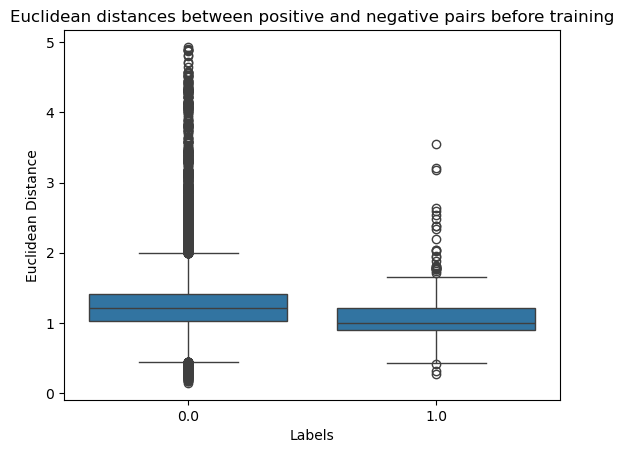

In [70]:
distances = []
labels = []
with torch.no_grad():
    with tqdm.tqdm(total=len(train_loader)) as pbar:
        for batch in train_loader:
            pbar.update(1)

            batch_phage = encoder(batch[0].to(device))
            batch_bacteria = encoder(batch[1].to(device))
            batch_labels = batch[2].to(device)
            
            distances.append(torch.sqrt(torch.sum(torch.pow(batch_phage - batch_bacteria, 2), 1)).cpu())
            labels.append(batch_labels.cpu())

    distances = np.concatenate(distances)
    labels = np.concatenate(labels)

    temp = pd.DataFrame([distances, labels], index=['Euclidean Distance', 'Labels']).transpose()
    gb = temp.groupby('Labels')
    print(gb.mean())
    print(gb.min())
    print(gb.max())
    plt.title('Euclidean distances between positive and negative pairs before training')
    sns.boxplot(data=temp, x='Labels', y='Euclidean Distance')
    plt.show()

In [60]:
unique_test_phages = test['phage_id'].unique()
unique_test_bacteria = test['bacterial_id'].unique()

# test_phage_dataset = TestDataset(unique_test_phages, 'mean')
# test_bact_dataset = TestDataset(unique_test_bacteria, 'mean', phage=False)
test_phage_dataset = TestDataset(unique_test_phages, 'sum')
test_bact_dataset = TestDataset(unique_test_bacteria, 'sum', phage=False)
phage_loader = DataLoader(test_phage_dataset, batch_size=int(len(test_phage_dataset)/2))
bacteria_loader = DataLoader(test_bact_dataset, batch_size=int(len(test_bact_dataset)/2))

phage_ids, output_phage_embeddings = predict(phage_loader, encoder)
print(phage_ids.shape)
print(output_phage_embeddings.shape)

bact_ids, output_bact_embeddings = predict(bacteria_loader, encoder)
print(bact_ids.shape)
print(output_bact_embeddings.shape)

(213,)
(213, 512)
(247,)
(247, 512)


[1.1548969, 1.0631624, 0.80996066, 0.8733764, 0.5753119, 1.3797718, 1.3627619, 1.5963103, 1.0170525, 0.944071, 2.5232635, 1.0962404, 0.45197496, 1.0584451, 1.2543873, 1.3686757, 1.0492194, 1.5101935, 1.0858202, 1.0329655, 1.2524621, 1.6164806, 0.52737623, 1.1615635, 1.3534484, 1.330331, 0.9714699, 1.053198, 0.93385947, 0.91266495, 1.5428557, 1.2407244, 0.6222665, 1.4687259, 1.221862, 0.8280573, 1.2554663, 1.2635586, 1.3741885, 1.1183292, 1.7879838, 1.0044816, 1.100931, 0.9285183, 1.2954714, 1.2852508, 1.4551169, 1.3435844, 0.72631, 1.2416084, 1.0671549, 1.2076018, 1.8706498, 1.5168494, 0.6189422, 1.0415678, 1.1954005, 0.81070167, 1.2473937, 0.97625035, 1.2825834, 1.7323086, 0.9114221, 1.2731317, 1.596116, 1.4659834, 1.252409, 1.3140755, 1.3530216, 1.1676011, 1.3600354, 1.5169197, 1.6441232, 0.9509607, 1.4158727, 1.2076335, 1.1969011, 1.1300967, 1.0285425, 1.4910028, 1.0406779, 1.4015944, 1.6050721, 0.98153406, 1.1398071, 1.4721705, 0.9628155, 1.5436686, 1.1731526, 1.3067678, 1.1702446,

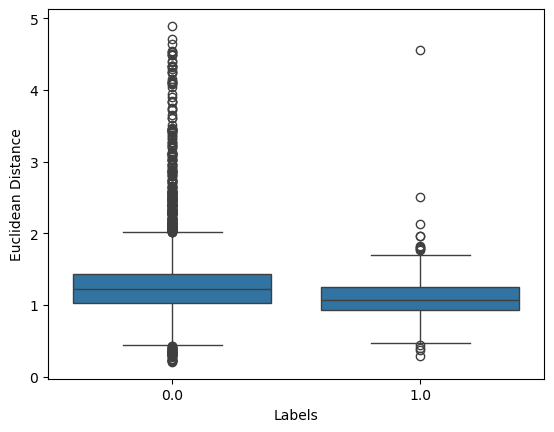

In [61]:
distances = []
labels = []
for i in range(test.index.shape[0]):
    phage = output_phage_embeddings[np.where(phage_ids == test.iloc[i]['phage_id'])[0]]
    bact = output_bact_embeddings[np.where(bact_ids == test.iloc[i]['bacterial_id'])[0]]
    distances.append(np.linalg.norm(phage-bact))
    labels.append(test.iloc[i]['Label'])

print(distances)
print(labels)

temp = pd.DataFrame([distances, labels], index=['Euclidean Distance', 'Labels']).transpose()
gb = temp.groupby('Labels')
print(gb.mean())
print(gb.min())
print(gb.max())
sns.boxplot(data=temp, x='Labels', y='Euclidean Distance')
plt.show()

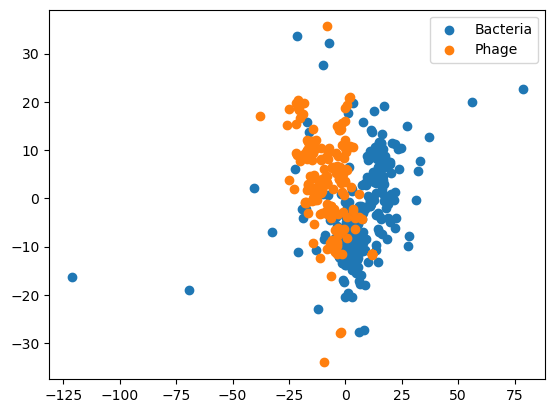

In [62]:
stacked_embeddings = np.concatenate([output_bact_embeddings, output_phage_embeddings])
stacked_embeddings_labels = np.array(['Bacteria']*len(output_bact_embeddings) + ['Phage']*len(output_phage_embeddings))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(stacked_embeddings)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[np.where(stacked_embeddings_labels == 'Bacteria')[0], 0], X_pca[np.where(stacked_embeddings_labels == 'Bacteria')[0], 1], label='Bacteria')
plt.scatter(X_pca[np.where(stacked_embeddings_labels == 'Phage')[0], 0], X_pca[np.where(stacked_embeddings_labels == 'Phage')[0], 1], label='Phage')
plt.legend()
plt.show()

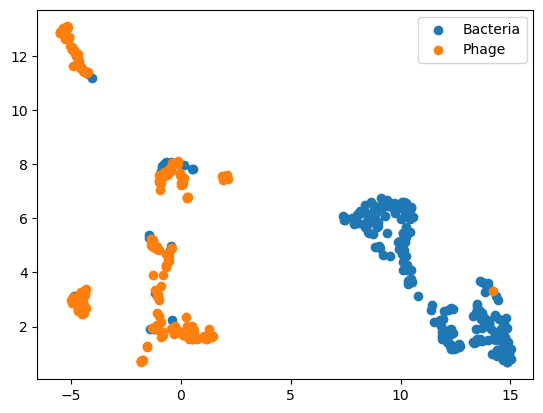

In [63]:
stacked_embeddings = np.concatenate([output_bact_embeddings, output_phage_embeddings])
stacked_embeddings_labels = np.array(['Bacteria']*len(output_bact_embeddings) + ['Phage']*len(output_phage_embeddings))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(stacked_embeddings)

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

mapper = umap.UMAP().fit_transform(X_pca)

plt.scatter(mapper[np.where(stacked_embeddings_labels == 'Bacteria')[0], 0], mapper[np.where(stacked_embeddings_labels == 'Bacteria')[0], 1], label='Bacteria')
plt.scatter(mapper[np.where(stacked_embeddings_labels == 'Phage')[0], 0], mapper[np.where(stacked_embeddings_labels == 'Phage')[0], 1], label='Phage')
plt.legend()
plt.show()

In [64]:
pair_embeddings = []
pair_labels = []

for i in range(len(test)):
    bact_embed = output_bact_embeddings[np.where(bact_ids == test.iloc[i]['bacterial_id'])[0]].reshape(-1)
    phage_embed = output_phage_embeddings[np.where(phage_ids == test.iloc[i]['phage_id'])[0]].reshape(-1)
    pair_embeddings.append(np.hstack([bact_embed, phage_embed]))
    pair_labels.append(test.iloc[i]['Label'])
print(len(pair_labels))

7892


(7892, 50)


/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


(7892, 2)


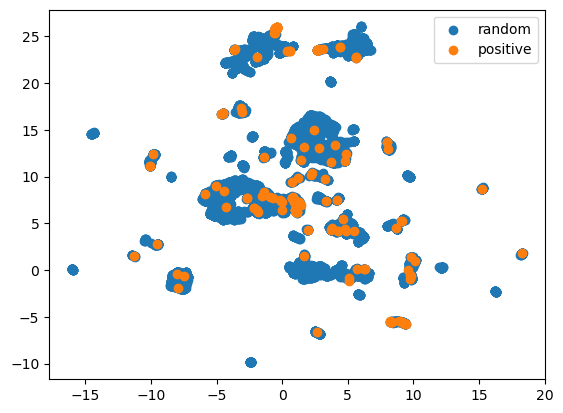

In [65]:
pair_labels = np.array(pair_labels)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pair_embeddings)

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

print(X_pca.shape)

mapper = umap.UMAP().fit_transform(X_pca)

print(mapper.shape)

plt.scatter(mapper[np.where(pair_labels == 0)[0], 0], mapper[np.where(pair_labels == 0)[0], 1], label='random')
plt.scatter(mapper[np.where(pair_labels == 1)[0], 0], mapper[np.where(pair_labels == 1)[0], 1], label='positive')
plt.legend()
plt.show()